In [145]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [146]:
# https://alt.qcri.org/semeval2016/task6/
datasets_names = ['hillary', 'feminist', 'climate', 'atheism', 'abortion']
datasets = dict()
for dataset in datasets_names:
    if dataset == 'atheism':
        df_train_features = pd.read_csv(f'stance/{dataset}/train_text.txt', sep='\s*\\t', names=['tweet'])
    else:
        df_train_features = pd.read_csv(f'stance/{dataset}/train_text.txt', names=['tweet'])
        
    df_train_labels = pd.read_csv(f'stance/{dataset}/train_labels.txt', names=['stance'])
    df_train = pd.concat([df_train_features,df_train_labels], axis=1, join='inner') 

    df_test_features = pd.read_csv(f'stance/{dataset}/test_text.txt', names=['tweet'])
    df_test_labels = pd.read_csv(f'stance/{dataset}/test_labels.txt', names=['stance'])
    df_test = pd.concat([df_test_features,df_test_labels], axis=1, join='inner') 

    df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
    
    datasets[dataset] = [df_train, df_val, df_test]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [147]:
datasets['atheism'][0].head()

,tweet,stance
0,"@user Bless Almighty God, Almighty Holy Spirit...",1
1,"Take away hatred from some people, and you hav...",1
2,I took my troubles to the Lord: I cried out to...,1
3,You can't think by yourself about life and bel...,2
4,RT @user Humanist love to everyone at #100AEUA...,0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0, 0, 'none'), Text(0, 0, 'against'), Text(0, 0, 'favor')]

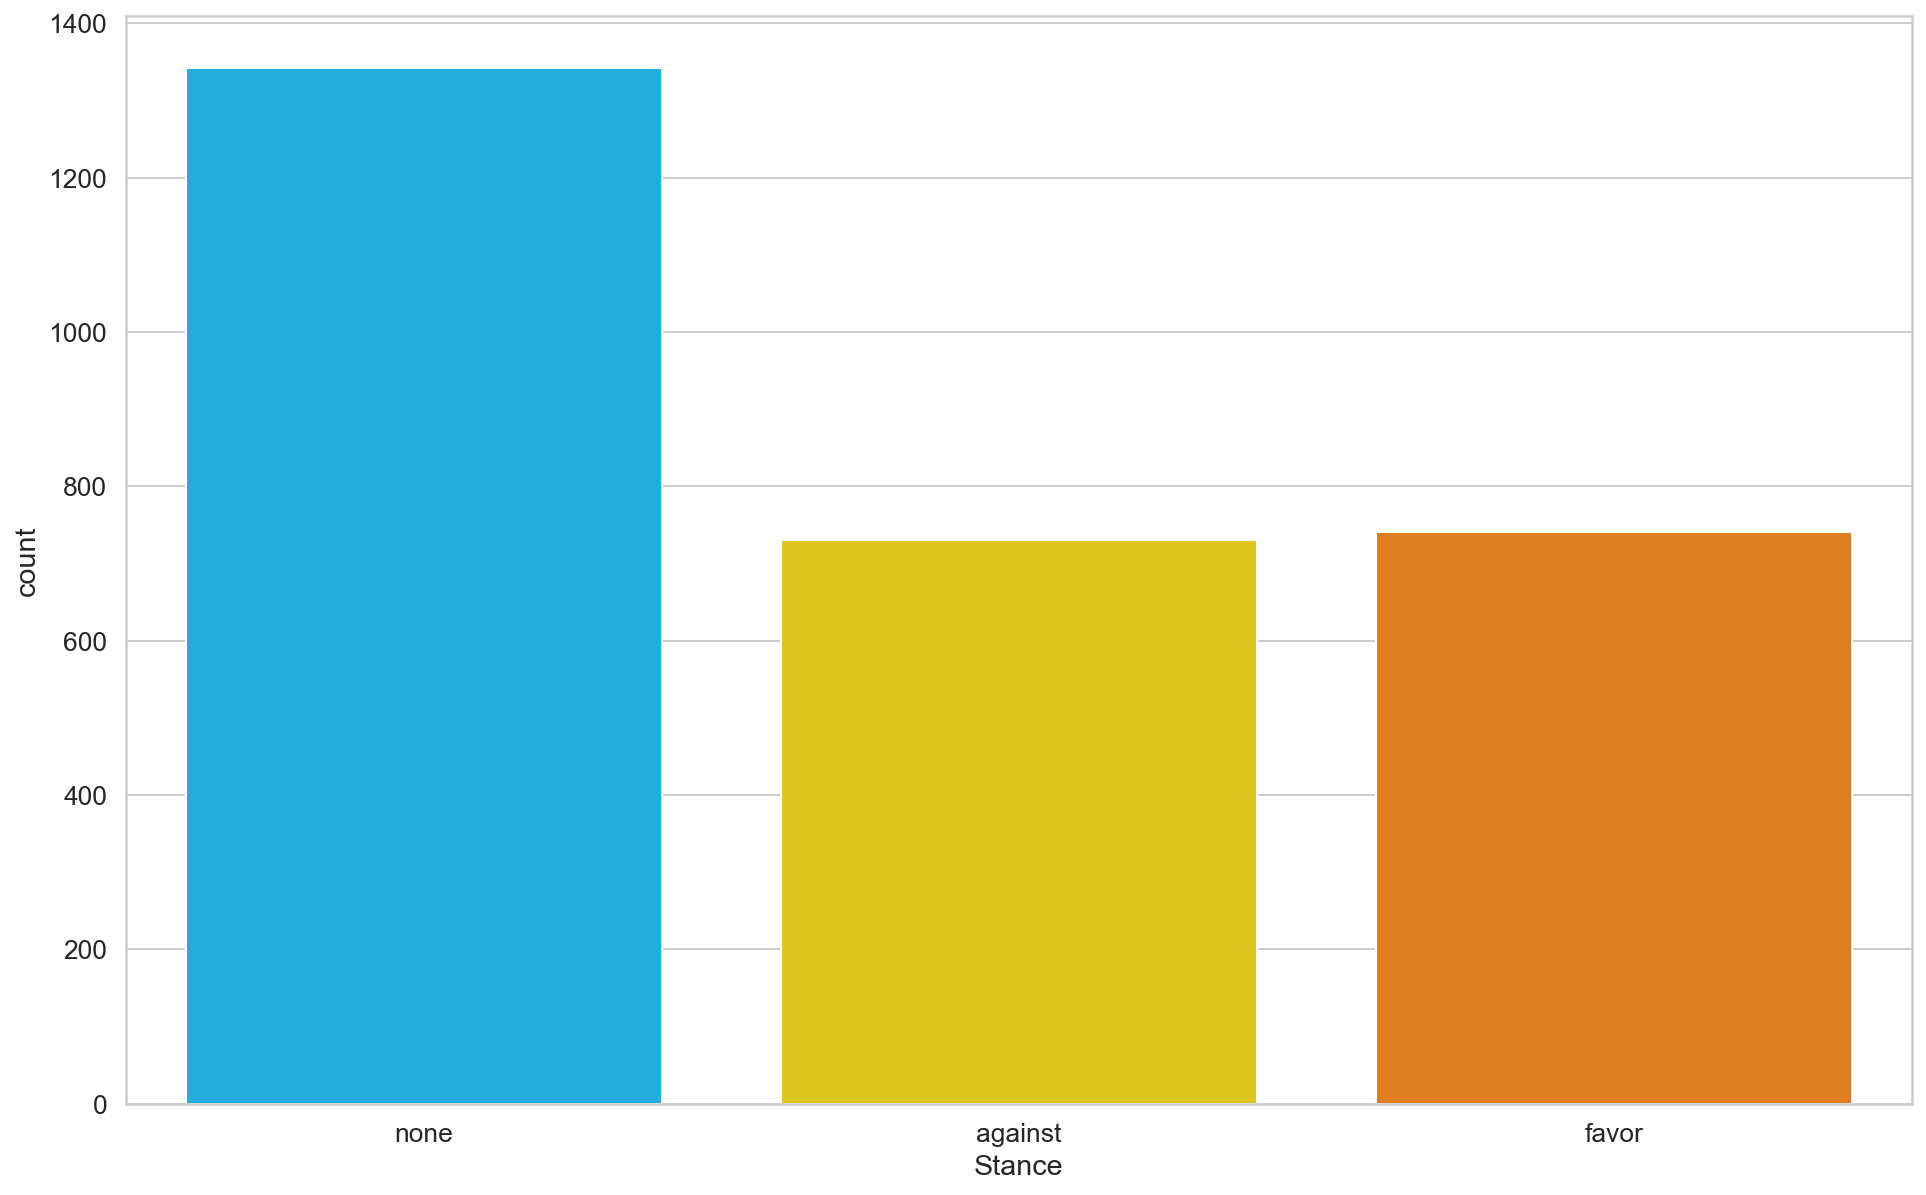

In [148]:
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

df_all = pd.read_csv('trainingdata-all-annotations.txt', sep='\s*\\t')
'''
g = sns.FacetGrid(df_all, col='Target')
g.map(sns.distplot, "Stance")
'''

ax = sns.countplot(df_all['Stance'])
class_names = ['none', 'against', 'favor']
ax.set_xticklabels(class_names)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


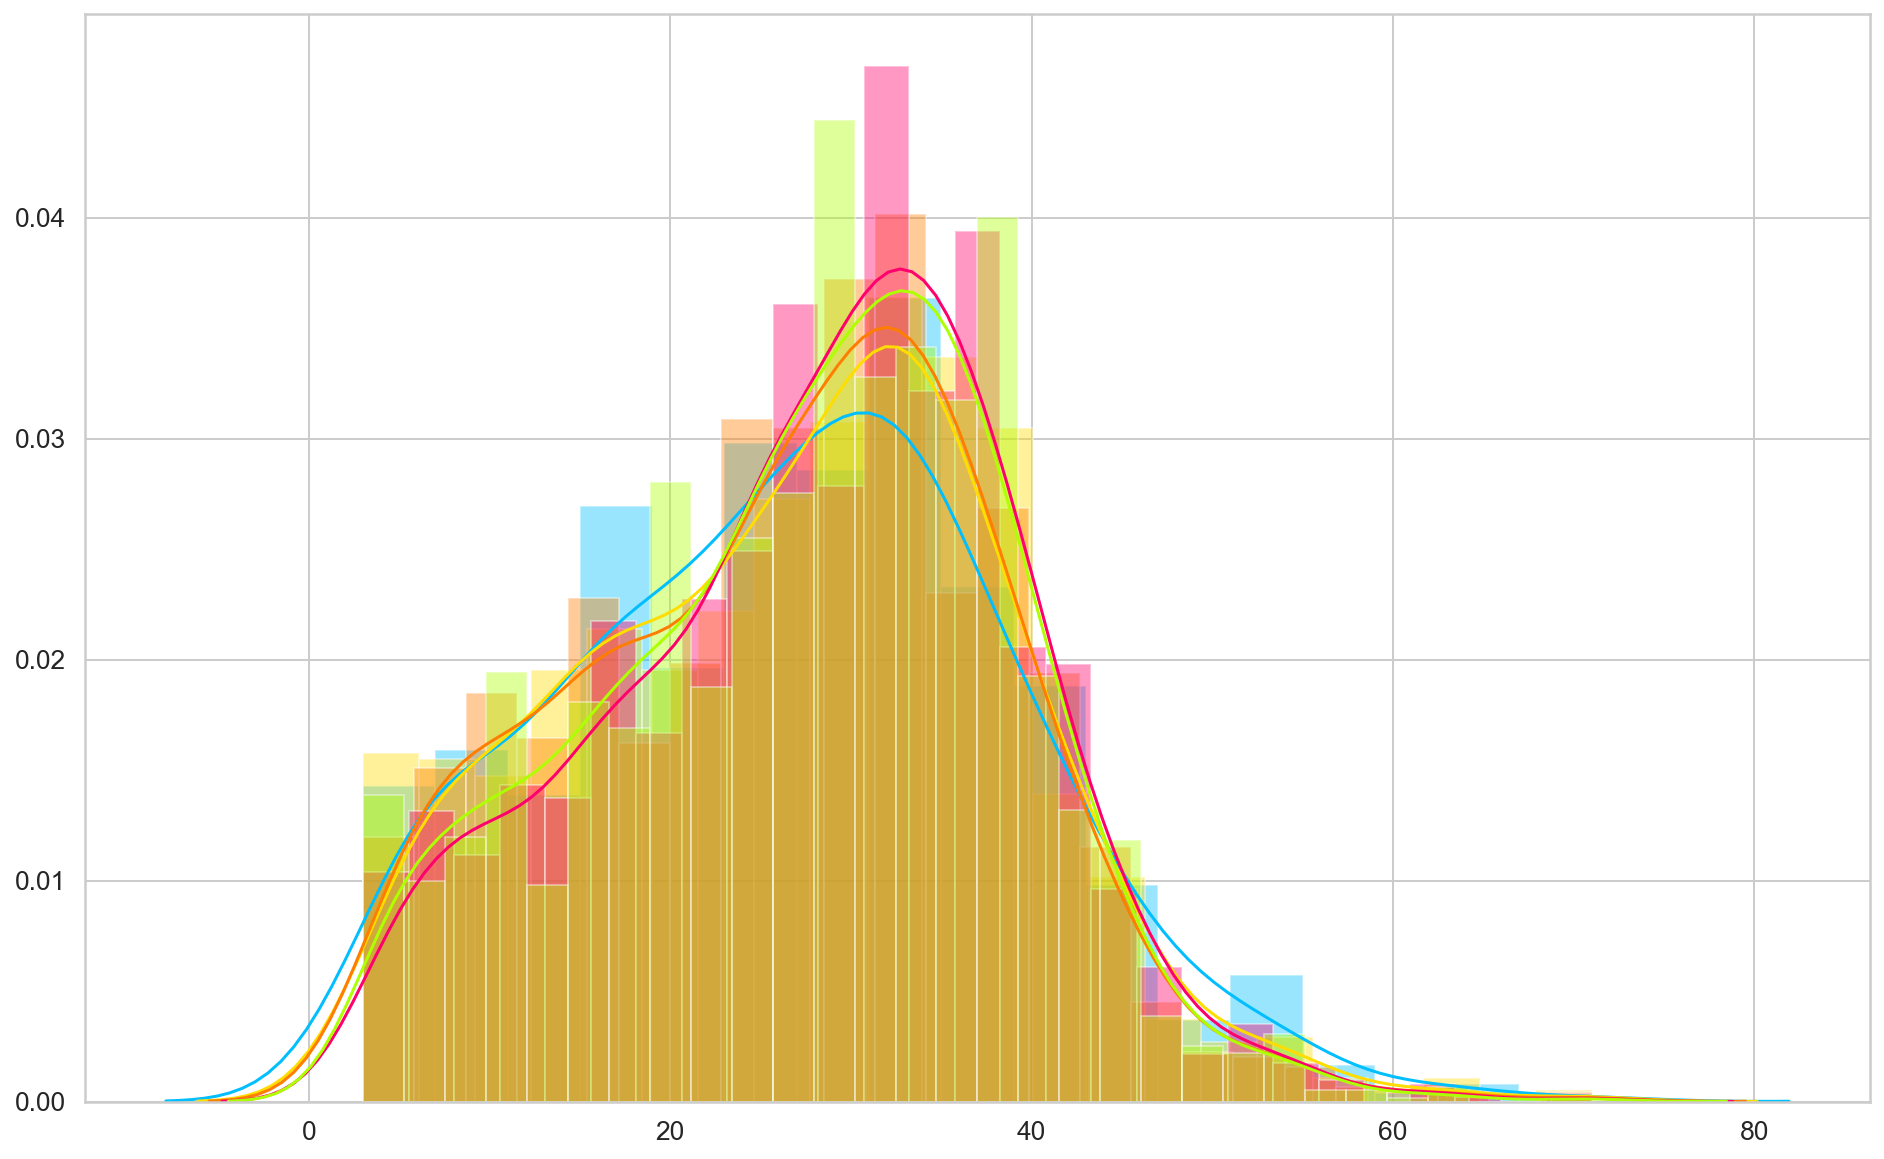

In [149]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Choosing sequence length

tokens_lens = []
for dt in datasets.values():
    for txt in dt[0]['tweet']:
        tokens = tokenizer.encode(txt, max_length=512)
        tokens_lens.append(len(tokens))

    sns.distplot(tokens_lens)

In [150]:
MAX_LEN = 70

class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [151]:
for k, dt in datasets.items():
    print(k,'dataset\nshape:', dt[0].shape, dt[1].shape, dt[2].shape)
    print('class distribution:\n', dt[0]['stance'].value_counts(), '\n', sep='')

hillary dataset
shape: (612, 2) (147, 2) (148, 2)
class distribution:
1    352
0    155
2    105
Name: stance, dtype: int64

feminist dataset
shape: (597, 2) (142, 2) (143, 2)
class distribution:
1    295
2    189
0    113
Name: stance, dtype: int64

climate dataset
shape: (355, 2) (84, 2) (85, 2)
class distribution:
2    191
0    151
1     13
Name: stance, dtype: int64

atheism dataset
shape: (461, 2) (100, 2) (101, 2)
class distribution:
1    273
0    105
2     83
Name: stance, dtype: int64

abortion dataset
shape: (586, 2) (140, 2) (140, 2)
class distribution:
1    318
0    159
2    109
Name: stance, dtype: int64



In [152]:
df = GPReviewDataset(
    reviews=df_train['tweet'].to_numpy(),
    targets=df_train['stance'].to_numpy(),
    tokenizer=tokenizer,
    max_len=70
  )

In [153]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['tweet'].to_numpy(),
        targets=df['stance'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
      )

In [154]:
BATCH_SIZE = 128

data_loaders = dict()
for k, dt in datasets.items():
    
    train_data_loader = create_data_loader(dt[0], tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(dt[1], tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(dt[2], tokenizer, MAX_LEN, BATCH_SIZE)
    
    data_loaders[k] = {'train_data_loader': train_data_loader, 'val_data_loader': val_data_loader, 
                      'test_data_loader': test_data_loader, 'df_train' :dt[0] , 'df_val': dt[1], 'df_test': dt[2]}

In [155]:
data = next(iter(data_loaders['hillary']['train_data_loader']))
data.keys()

//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [156]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([128, 70])
torch.Size([128, 70])
torch.Size([128])


In [157]:
bert_model = BertModel.from_pretrained('bert-base-cased')

class StanceClassifier(nn.Module):

    def __init__(self, n_classes):
        super(StanceClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        tuple_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        pooled_output = tuple_output[1]
        
        output = self.drop(pooled_output)
        return self.out(output)

In [158]:
model = StanceClassifier(len(class_names))

In [159]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product


class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

In [160]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"]
        attention_mask = d["attention_mask"]
        targets = d["targets"]
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [161]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)

In [169]:
params = OrderedDict(
    lr = [3e-5], #5e-5, 3e-5, 2e-5
    epochs = [4] #2, 3, 4
)

history = defaultdict(list)
for target, dt in data_loaders.items():
    print(f'Target: {target}')
    model = StanceClassifier(len(class_names))

    for run in RunBuilder.get_runs(params):


        EPOCHS = run.epochs

        optimizer = AdamW(model.parameters(), lr=run.lr, correct_bias=False)
        total_steps = len(dt['train_data_loader']) * EPOCHS

        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=0,
          num_training_steps=total_steps
        )

        loss_fn = nn.CrossEntropyLoss(torch.Tensor(datasets[target][3]))

        #%%time

        best_accuracy = 0

        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_acc, train_loss = train_epoch(
              model,
              dt['train_data_loader'],    
              loss_fn, 
              optimizer, 
              device, 
              scheduler, 
              len(dt['df_train'])
            )

            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = eval_model(
              model,
              dt['val_data_loader'],
              loss_fn, 
              device, 
              len(dt['df_val'])
            )

            print(f'Val loss {val_loss} accuracy {val_acc}')
            print()

            history[f'{target}_train_acc'].append(train_acc)
            history[f'{target}_train_loss'].append(train_loss)
            history[f'{target}_val_acc'].append(val_acc)
            history[f'{target}_val_loss'].append(val_loss)

            if val_acc > best_accuracy:
                torch.save(model.state_dict(), f'best_model_state_{target}.bin')
                best_accuracy = val_acc

Target: hillary
Epoch 1/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1477115631103516 accuracy 0.28431372549019607


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.0984195470809937 accuracy 0.1360544217687075

Epoch 2/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1393877267837524 accuracy 0.3660130718954248


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.0901763439178467 accuracy 0.6258503401360545

Epoch 3/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1253132343292236 accuracy 0.3888888888888889


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.063408613204956 accuracy 0.3877551020408163

Epoch 4/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1009604215621949 accuracy 0.3300653594771242


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.1081281304359436 accuracy 0.17006802721088435

Target: feminist
Epoch 1/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1239681959152221 accuracy 0.3685092127303183


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.0844687819480896 accuracy 0.2535211267605634

Epoch 2/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9818727850914002 accuracy 0.45896147403685095


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.8831291198730469 accuracy 0.5

Epoch 3/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.8273539423942566 accuracy 0.5778894472361809


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.8756035566329956 accuracy 0.4859154929577465

Epoch 4/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6813228964805603 accuracy 0.6298157453936348


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.8500755727291107 accuracy 0.49295774647887325

Target: climate
Epoch 1/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1775798002878826 accuracy 0.2647887323943662


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.1420384645462036 accuracy 0.20238095238095238

Epoch 2/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0154114961624146 accuracy 0.4788732394366197


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.033610224723816 accuracy 0.6785714285714286

Epoch 3/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9146725138028463 accuracy 0.5408450704225352


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.1505177021026611 accuracy 0.4166666666666667

Epoch 4/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.7775129874547323 accuracy 0.6422535211267606


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.0897918939590454 accuracy 0.5476190476190477

Target: atheism
Epoch 1/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.148275226354599 accuracy 0.3644251626898048


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.0555503368377686 accuracy 0.72

Epoch 2/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0898208618164062 accuracy 0.4598698481561822


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.093127727508545 accuracy 0.44

Epoch 3/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9654255658388138 accuracy 0.5639913232104121


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.1597181558609009 accuracy 0.51

Epoch 4/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.8800905793905258 accuracy 0.6550976138828634


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val loss 1.2351315021514893 accuracy 0.41

Target: abortion
Epoch 1/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.1764937162399292 accuracy 0.363481228668942


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.0861377120018005 accuracy 0.6

Epoch 2/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0907389640808105 accuracy 0.34812286689419797


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 1.0169807076454163 accuracy 0.5

Epoch 3/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0256081819534302 accuracy 0.5426621160409556


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.9485199153423309 accuracy 0.38571428571428573

Epoch 4/4
----------


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9431774735450744 accuracy 0.5


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.9983413219451904 accuracy 0.42857142857142855



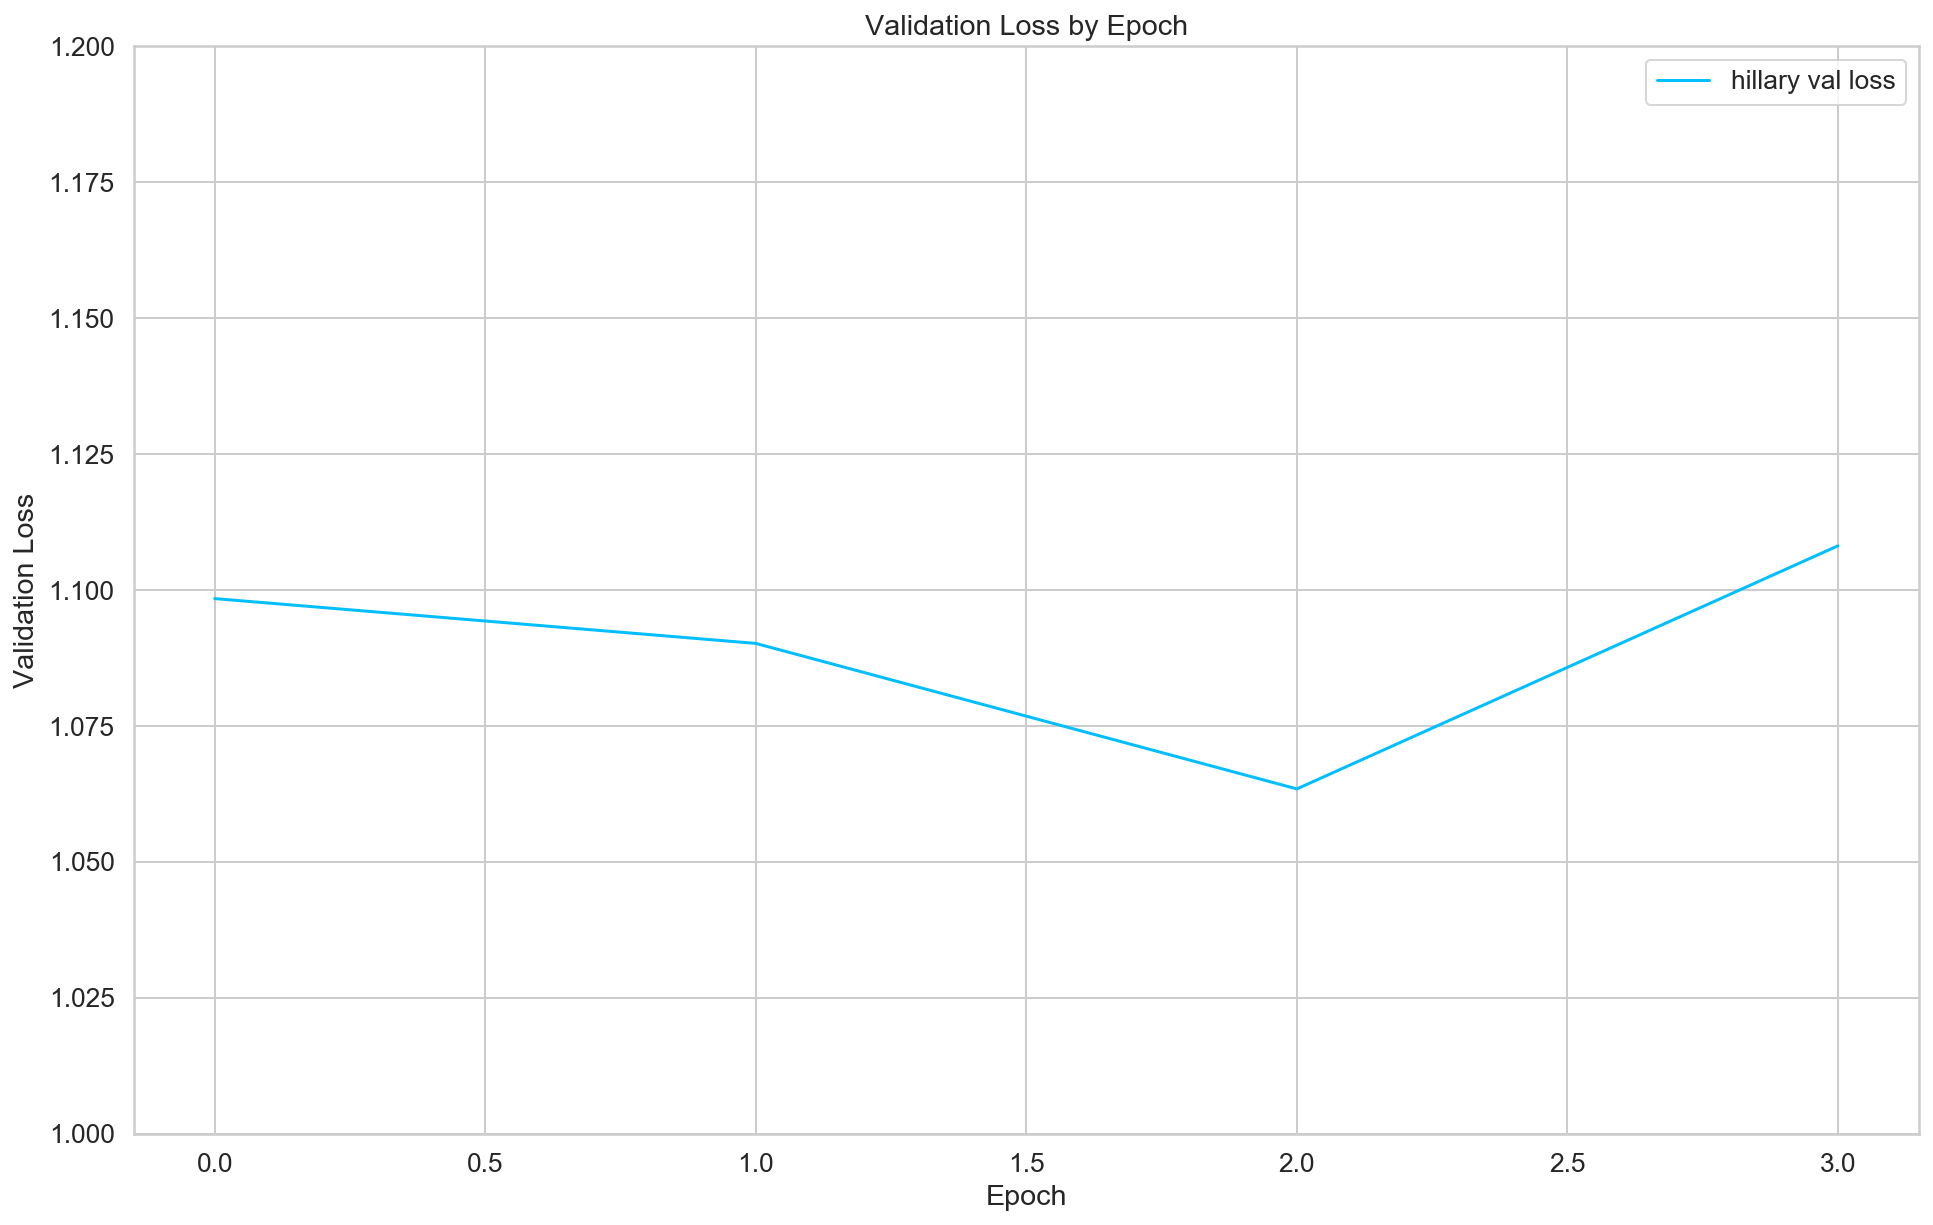

In [180]:
plt.plot(history['hillary_val_loss'], label='hillary val loss')
plt.title('Validation Loss by Epoch')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([1, 1.2]);  

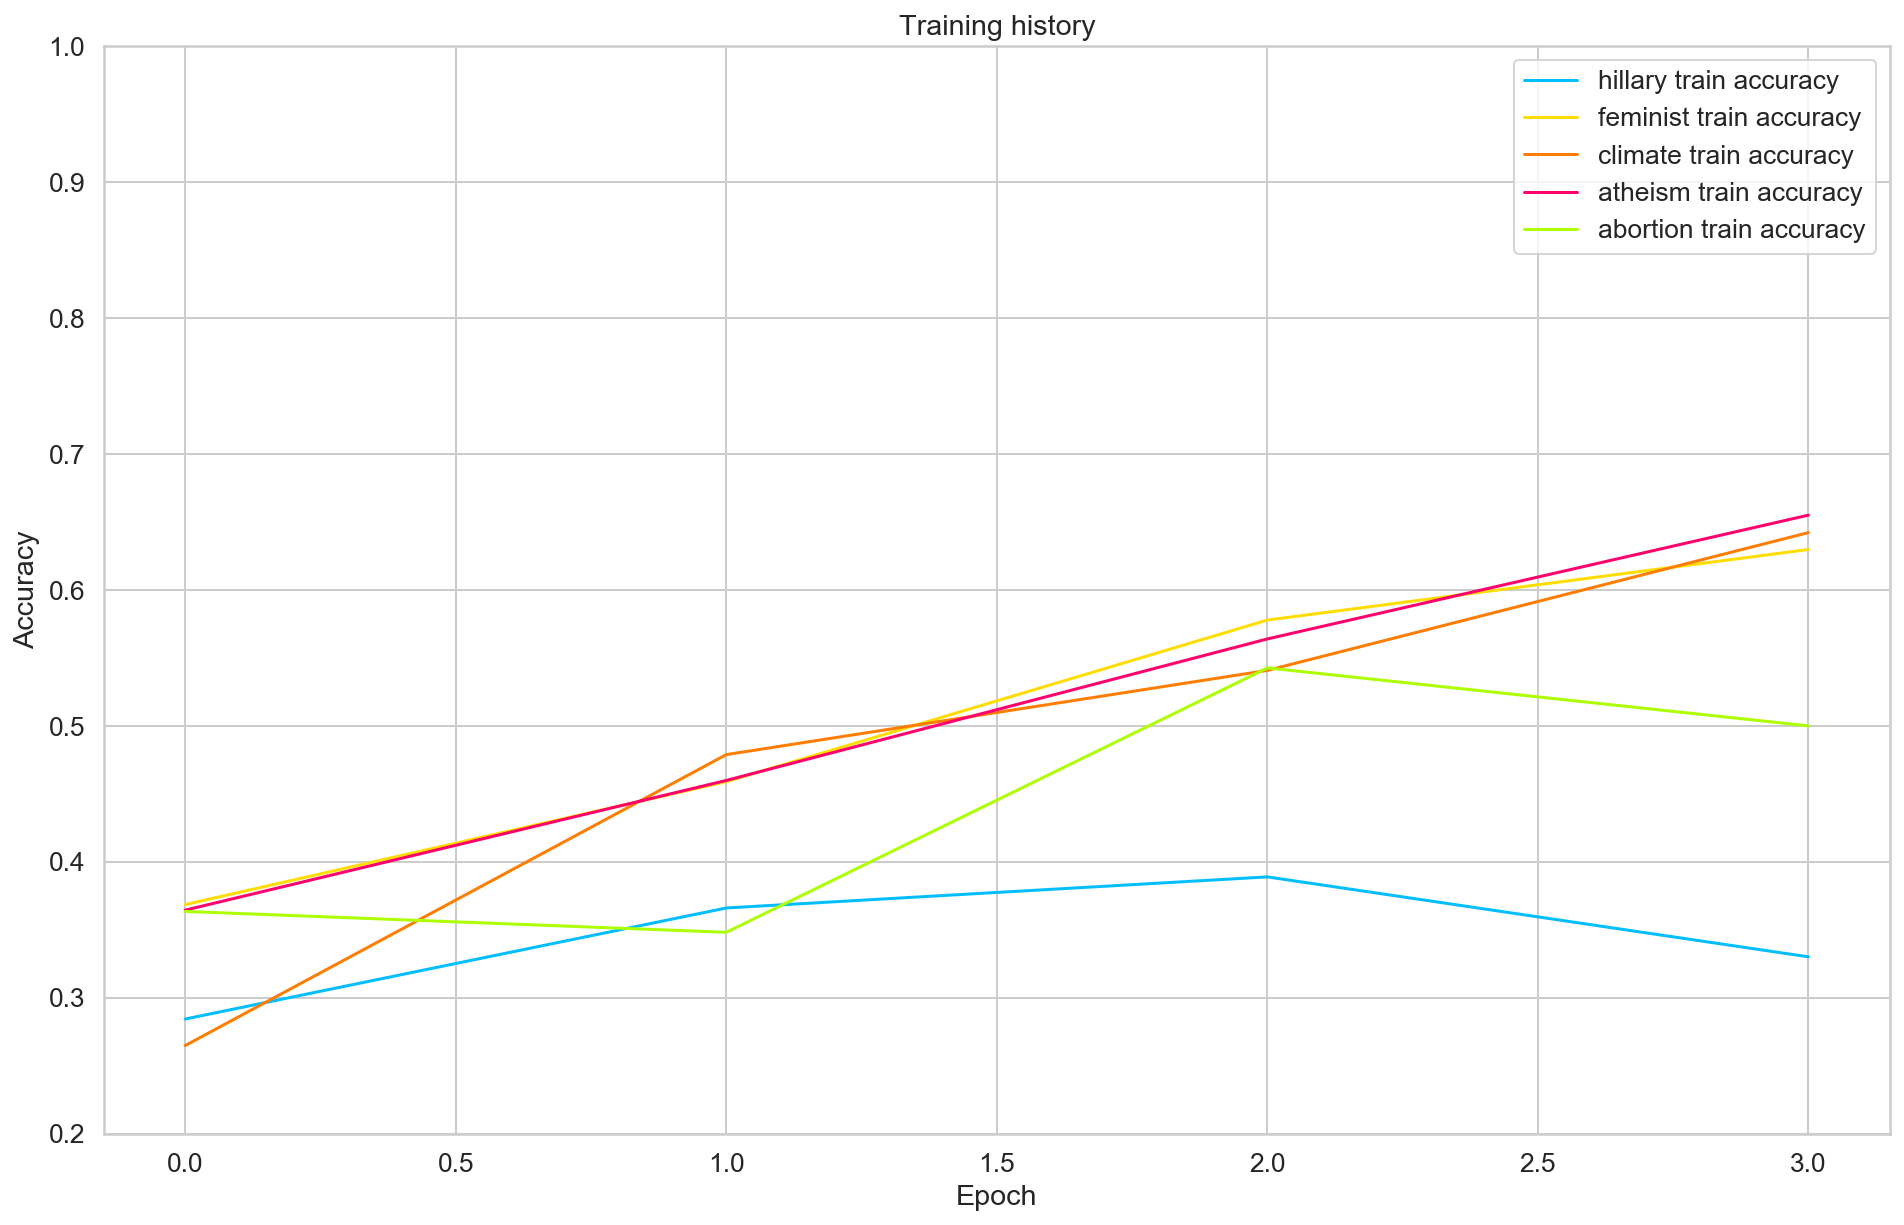

In [181]:
for target in data_loaders.keys():
    plt.plot([i.item() for i in history[f'{target}_train_acc']], label=f'{target} train accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0.2, 1]);   

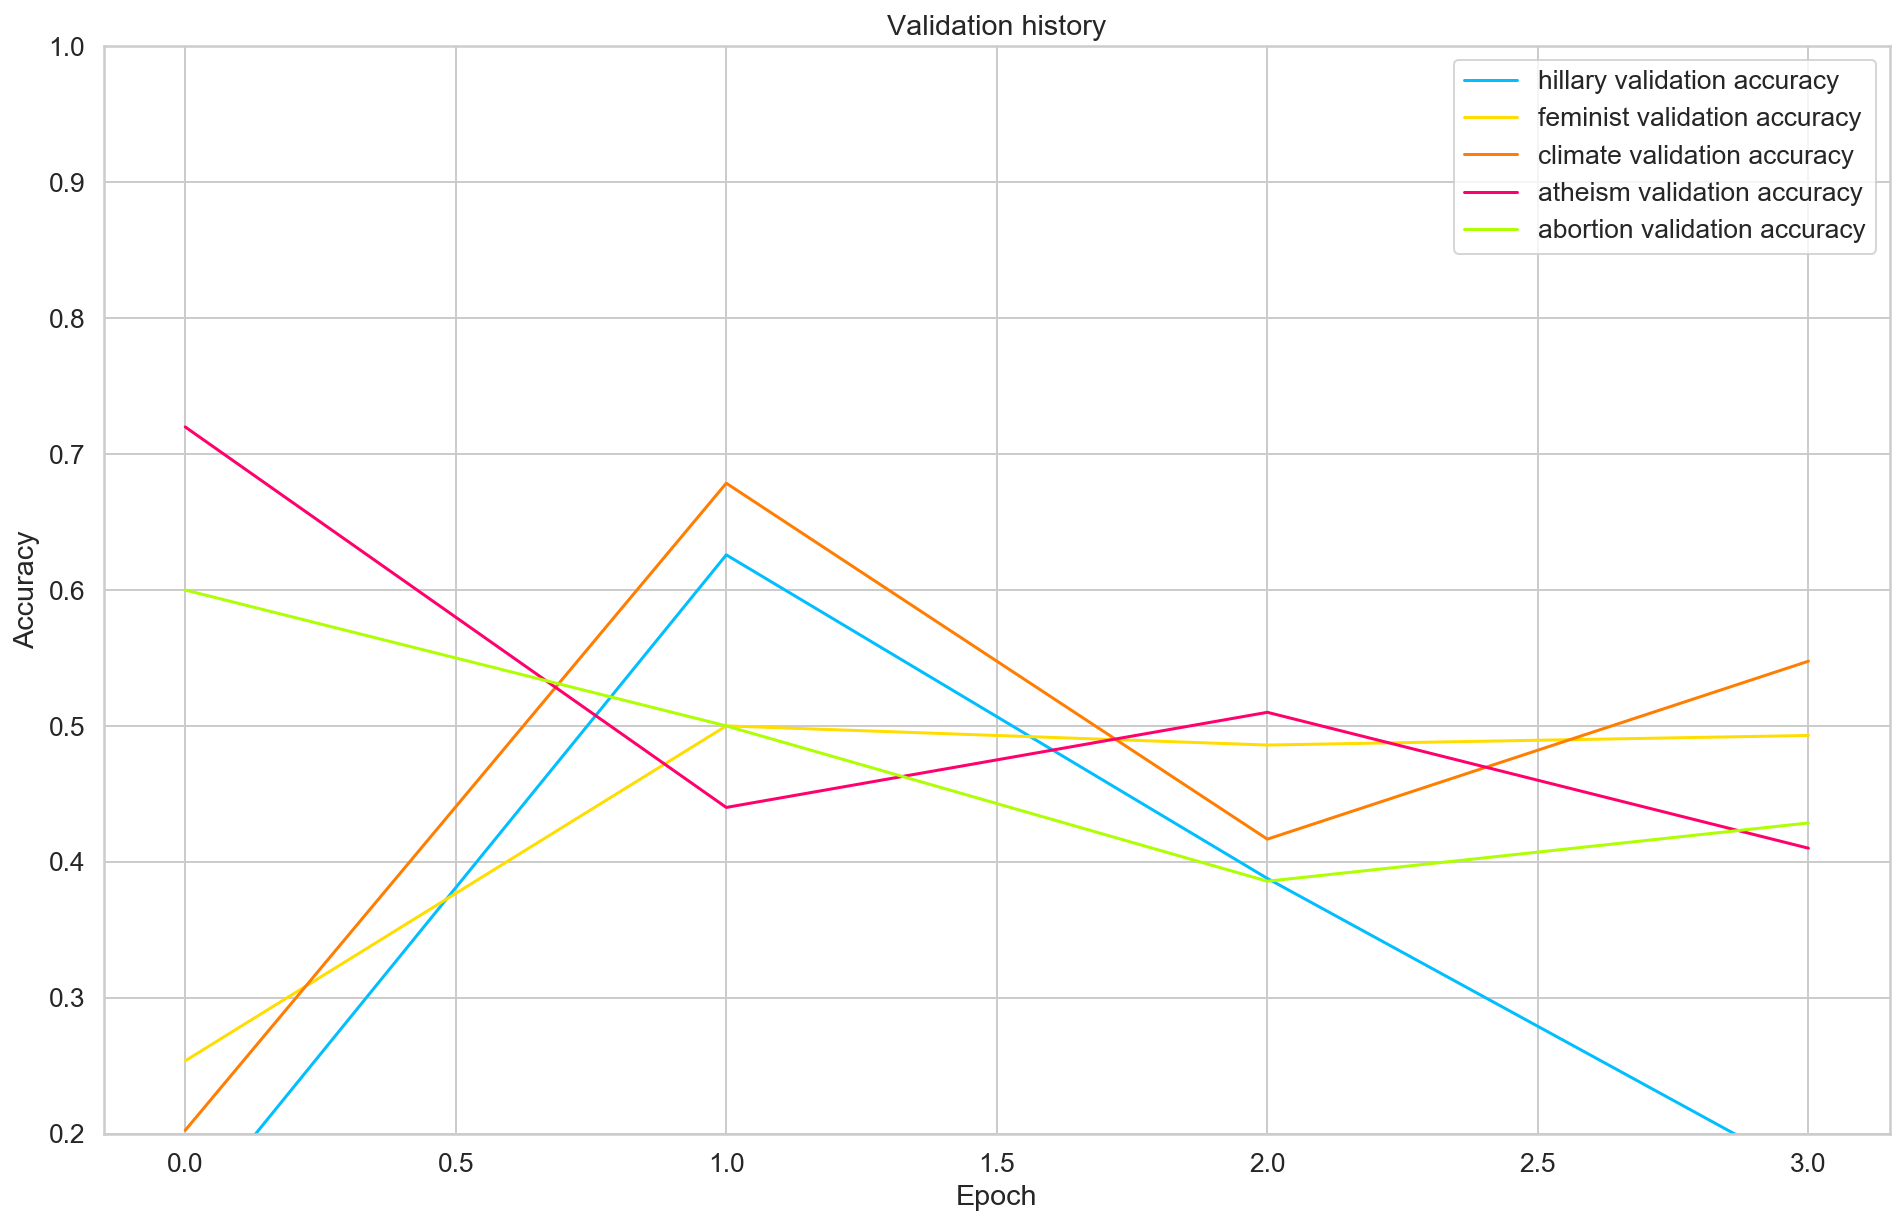

In [182]:
for target in data_loaders.keys():
    plt.plot(history[f'{target}_val_acc'], label=f'{target} validation accuracy')
    plt.title('Validation history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0.2, 1]);

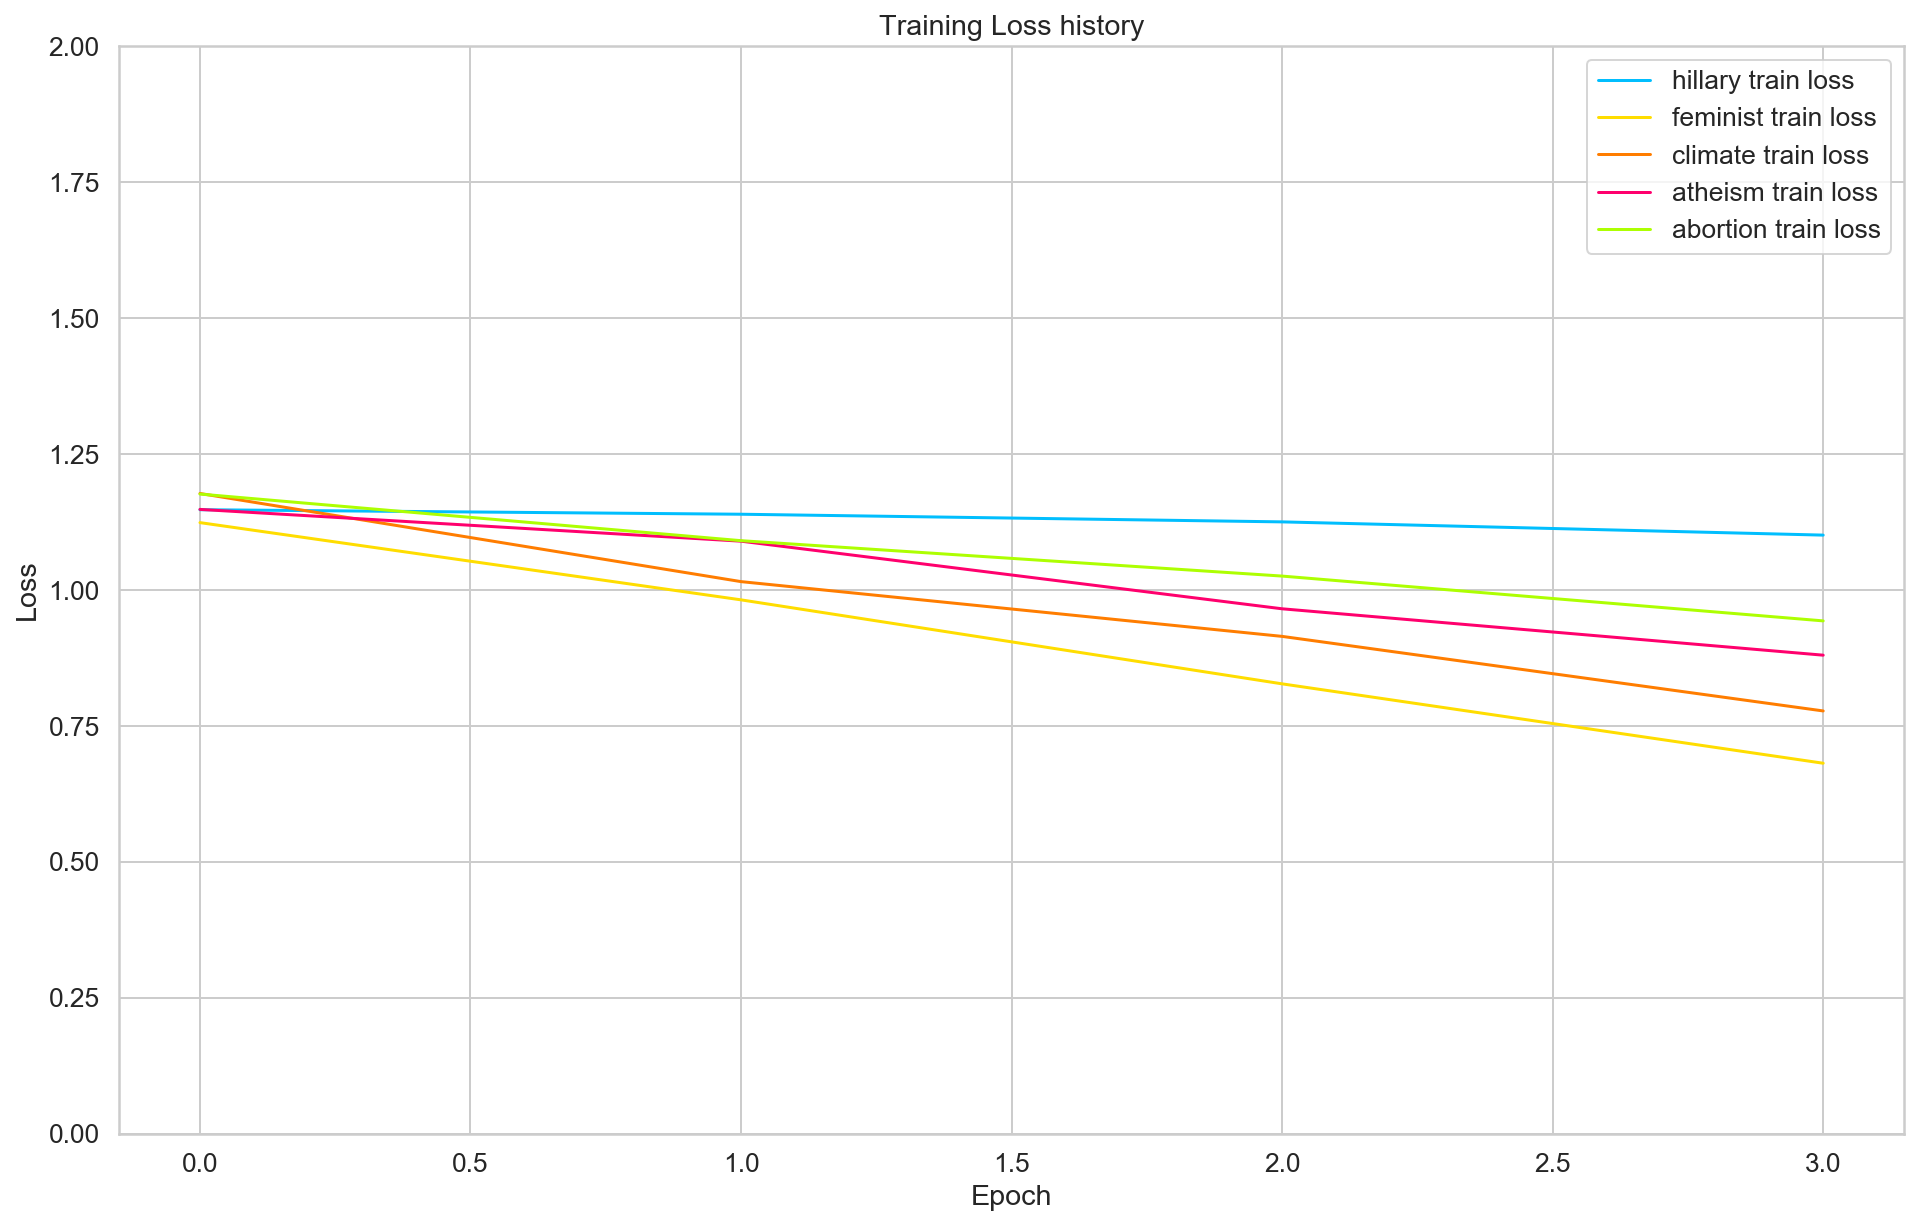

In [183]:
for target in data_loaders.keys():
    plt.plot([i.item() for i in history[f'{target}_train_loss']], label=f'{target} train loss')
    plt.title('Training Loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 2]); 

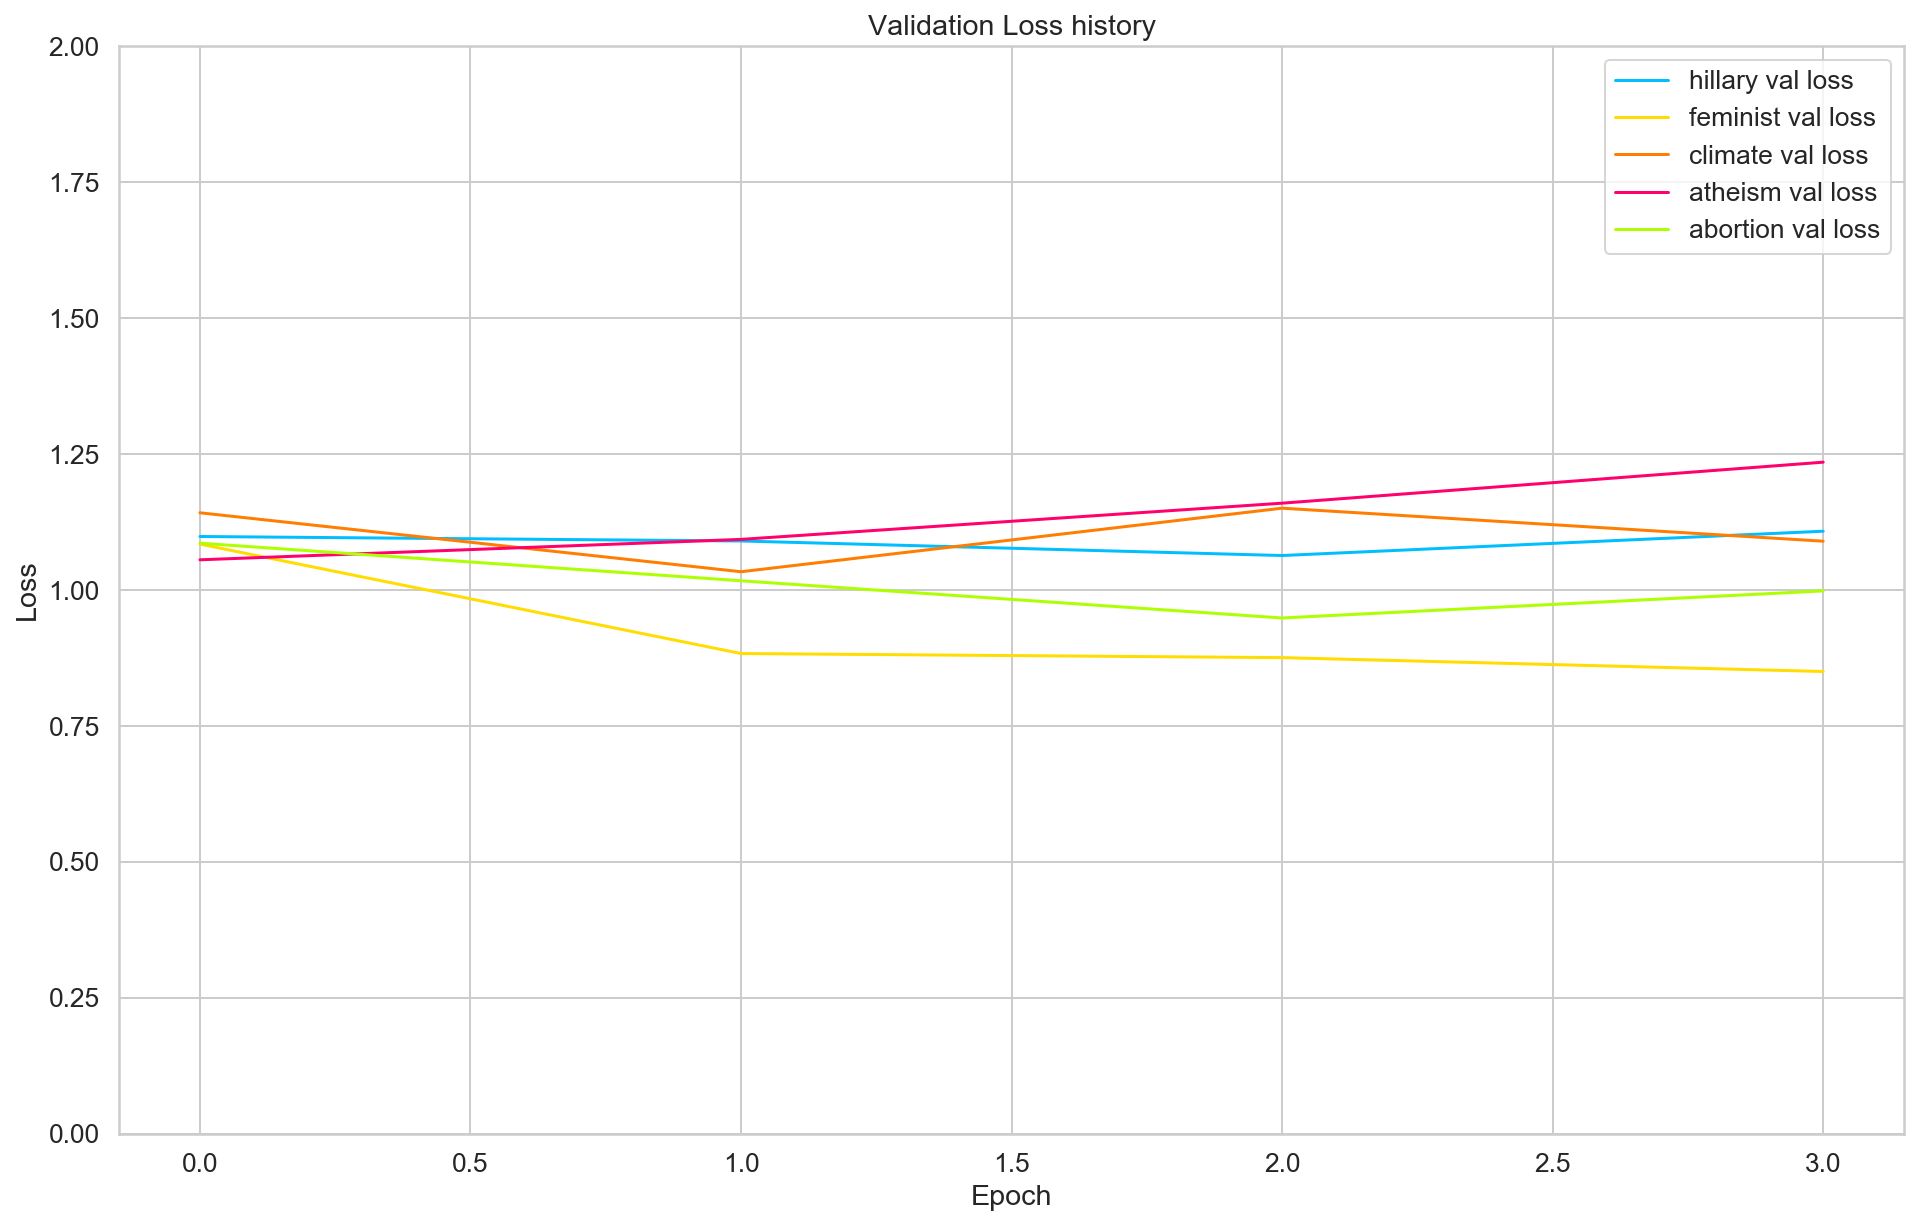

In [184]:
for target in data_loaders.keys():
    plt.plot([i.item() for i in history[f'{target}_val_loss']], label=f'{target} val loss')
    plt.title('Validation Loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 2]); 

In [173]:
for target, dt in data_loaders.items():

    model = StanceClassifier(len(class_names))
    model.load_state_dict(torch.load(f'best_model_state_{target}.bin'))

    test_acc, _ = eval_model(
      model,
      dt['test_data_loader'],
      loss_fn,
      device,
      len(dt['df_test'])
    )

    print(f'{target} test acc: {test_acc.item()}')

//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

hillary test acc: 0.5202702702702703


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

feminist test acc: 0.4965034965034965


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


climate test acc: 0.7294117647058823


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


atheism test acc: 0.7623762376237624


//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

abortion test acc: 0.5571428571428572


In [174]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [175]:
predictions = defaultdict(list)

for target, dt in data_loaders.items():
    
    model = StanceClassifier(len(class_names))
    model.load_state_dict(torch.load(f'best_model_state_{target}.bin'))
    
    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
      model,
      dt['test_data_loader']
    )
    
    predictions[f'{target}_preds'].append(y_review_texts)
    predictions[f'{target}_preds'].append(y_pred)
    predictions[f'{target}_preds'].append(y_pred_probs)
    predictions[f'{target}_preds'].append(y_test)

//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
//anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [185]:
for target, preds in predictions.items():
    y_test = preds[3]
    y_pred = preds[1]
    print(target)
    print(classification_report(y_test, y_pred, target_names=class_names))

hillary_preds
              precision    recall  f1-score   support

        none       0.00      0.00      0.00        42
     against       0.55      0.92      0.69        79
       favor       0.29      0.15      0.20        27

    accuracy                           0.52       148
   macro avg       0.28      0.36      0.29       148
weighted avg       0.35      0.52      0.40       148

feminist_preds
              precision    recall  f1-score   support

        none       0.45      0.68      0.55        22
     against       0.80      0.42      0.55        92
       favor       0.28      0.59      0.38        29

    accuracy                           0.50       143
   macro avg       0.51      0.56      0.49       143
weighted avg       0.64      0.50      0.52       143

climate_preds
              precision    recall  f1-score   support

        none       0.59      0.59      0.59        17
     against       0.17      0.14      0.15         7
       favor       0.82      0.8

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [156]:
predictions['hillary_preds'][1], predictions['hillary_preds'][3]

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 tensor([2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
         1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 2, 2,
         2, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1,
         1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1,
         1, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0,
         1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 1,
     

### Utilizando simpletransformers, testando modelos mais simples e outras configuracoes

In [200]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 317kB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 51kB 8.5MB/s  eta 0:00:01
     |████████████████████████████████| 2.0MB 7.8MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 40.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/98/87/ef312eef26f5cecd8b17ae9654cdd8d1fae1eb6dbd87257d6d73c128a4d0/transformers-4.3.2-py3-none-any.whl
     |████████████████████████████████| 81kB 26.5MB/s eta 0:00:01
     |████████████████████████████████| 7.5MB 9.1MB/s eta 0:00:01
     |████████████████████████████████| 163kB 32.0MB/s eta 0:00:01
     |████████████████████████████████| 102kB 20.7MB/s ta 0:00:01
     |████████████████████████████████| 133kB 5.6MB/s eta 0:00:01
     |████████████████████████████████| 4.6MB 34.9MB/s eta 0:00:01


  Using cached https://files.pythonhosted.org/packages/44/6f/7120676b6d73228c96e17f1f794d8ab046fc910d781c8d151120c3f1569e/toml-0.10.2-py2.py3-none-any.whl
     |████████████████████████████████| 112kB 33.7MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 21.3MB/s eta 0:00:01
     |████████████████████████████████| 737kB 10.9MB/s eta 0:00:01
     |████████████████████████████████| 14.1MB 12.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 20.2MB/s eta 0:00:01
     |████████████████████████████████| 122kB 7.1MB/s eta 0:00:01


  Stored in directory: /Users/rodrigoludermir/Library/Caches/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Stored in directory: /Users/rodrigoludermir/Library/Caches/pip/wheels/19/49/34/c3c1e78bcb954c49e5ec0d31784fe63d14d427f316b12fbde9
  Stored in directory: /Users/rodrigoludermir/Library/Caches/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Stored in directory: /Users/rodrigoludermir/Library/Caches/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Stored in directory: /Users/rodrigoludermir/Library/Caches/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built seqeval promise subprocess32 pathtools blinker
ERROR: transformers 4.3.2 has requirement tokenizers<0.11,>=0.10.1, but you'll have tokenizers 0.9.4 which is incompatible.
ERROR: seqeval 1.2.2 has requirement scikit-learn>=0.21.3, but you'll have scikit-learn 0.21.2 which is incompatible.
ERROR: wandb 0.10.19 has require

In [221]:
!pip install imblearn

     |████████████████████████████████| 174kB 977kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f9/67/cf40f5f74a4619469c97f5351770e7bec7ab54b52fa838586eee03c4bdca/scikit_learn-0.24.1-cp37-cp37m-macosx_10_13_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/12/ec3f2e203afa394a149911729357aa48affc59c20e2c1c8297a60f33f133/threadpoolctl-2.1.0-py3-none-any.whl
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2


In [64]:

h_train = datasets['hillary'][0]
h_val = datasets['hillary'][1]
h_test = datasets['hillary'][2]

f_train = datasets['feminist'][0]

In [95]:
h_train['stance'].value_counts()
#h_test['stance'].value_counts()
#f_train['stance'].value_counts()

1    352
0    155
2    105
Name: stance, dtype: int64

### reshaping com undersampling

In [52]:
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import RandomUnderSampler

for target, data in datasets.items():

    X = data[0]['tweet'].values.reshape(data[0]['tweet'].shape[0], 1)
    y = data[0]['stance'].values.reshape(data[0]['stance'].shape[0], 1)

    resample = {1:105, 0:105, 2:105}

    nm = RandomUnderSampler(sampling_strategy=resample)
    X_res, y_res = nm.fit_sample(X,y)

    X = pd.DataFrame(X_res, columns=['tweet'])
    y = pd.DataFrame(y_res, columns=['stance'])
    h_train = pd.concat([X,y], axis=1, join='inner')

### Assinalando pesos para as classes

In [167]:
from collections import OrderedDict 


def assinalar_pesos(menor, medio, maior):
    w_medio = 1
    w_maior = medio[1] / maior[1]
    w_menor = medio[1] / menor[1]
    
    menor = (menor[0], w_menor)
    medio = (medio[0], w_medio)
    maior = (maior[0], w_maior)
    
    weights = sorted([menor, medio, maior] ,key=lambda x: x[0])
    weigths = [i[1] for i in weights]
    return weigths


for target, data in datasets.items():

    df_train = data[0]
    df_val = data[1]
    df_test = data[2]
    

    distribution = {
        0 : df_train['stance'].value_counts()[0],
        1 : df_train['stance'].value_counts()[1],
        2 : df_train['stance'].value_counts()[2]
    }

    distribution = dict(sorted(distribution.items(), key=lambda item: item[1]))

    menor = list(distribution.items())[0]
    medio = list(distribution.items())[1]
    maior = list(distribution.items())[2]

    weights = assinalar_pesos(menor, medio, maior)
    datasets[target].append(weights)

In [129]:
from simpletransformers.classification import ClassificationModel

models = dict()

for target, data in datasets.items():
    print(f'training {target} dataset:')

    df_train = data[0]
    df_eval = data[1]


    # Configurando validacao
    steps_per_epoch = int(np.ceil(len(df_train) / float(32)))


    # hiperparametros
    args = {'learning_rate':3e-5,
            'num_train_epochs': 5, 
            'reprocess_input_data': True, 
            'overwrite_output_dir': True,
            'max_seq_length': 70,
            'train_batch_size': 32,
            'eval_batch_size': 32,
            'evaluate_during_training' : True,
            'evaluate_during_training_verbose' : True,
            'evaluate_during_training_steps' : steps_per_epoch,
            'use_cached_eval_features' : True
            }


    # Create a ClassificationModel
    bertweet_model = ClassificationModel('bertweet', 'vinai/bertweet-base', 
                                         num_labels=3, use_cuda=False, 
                                         weight=weights, args=args
                                        )


    bertweet_model.train_model(df_train, eval_df=df_eval)
    
    models[target] = bertweet_model

training hillary dataset:


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


training feminist dataset:


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using col

Running Epoch 1 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


training climate dataset:


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/12 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using col

Running Epoch 1 of 5:   0%|          | 0/12 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using col

Running Epoch 2 of 5:   0%|          | 0/12 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/12 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/12 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


training atheism dataset:


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/15 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/15 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/15 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/15 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/15 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


training abortion dataset:


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/19 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
//anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [131]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
results = dict()
for target, data in datasets.items():

    result, model_outputs, wrong_predictions = models[target].eval_model(data[2], f1=f1_multiclass, acc=accuracy_score)
    
    results[target] = {
        'result': result,
        'model_outputs': model_outputs,
        'wrong_predictions': wrong_predictions
    }

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [139]:
result, model_outputs, wrong_predictions = model.eval_model(datasets['abortion'][2], f1=f1_multiclass, acc=accuracy_score)
result

//anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

{'mcc': 0.28467104816763683,
 'f1': 0.5142857142857142,
 'acc': 0.5142857142857142,
 'eval_loss': 0.9588376164436341}

In [136]:
model = ClassificationModel(
    "bertweet", "outputs/best_model", use_cuda=False
)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [134]:
model_outputs_torch = torch.from_numpy(results['climate']['model_outputs'])
F.softmax(model_outputs_torch, dim=1), datasets['climate'][0]['stance']

(tensor([[0.2773, 0.0278, 0.6949],
         [0.1574, 0.0349, 0.8076],
         [0.0763, 0.0400, 0.8837],
         [0.1652, 0.0354, 0.7994],
         [0.2954, 0.0347, 0.6699],
         [0.4238, 0.0322, 0.5440],
         [0.0775, 0.0458, 0.8767],
         [0.0850, 0.0415, 0.8735],
         [0.0939, 0.0344, 0.8717],
         [0.0786, 0.0421, 0.8794],
         [0.2773, 0.0397, 0.6830],
         [0.0820, 0.0395, 0.8785],
         [0.0690, 0.0441, 0.8869],
         [0.0822, 0.0408, 0.8770],
         [0.0834, 0.0435, 0.8731],
         [0.2175, 0.0343, 0.7482],
         [0.0640, 0.0521, 0.8838],
         [0.0740, 0.0436, 0.8824],
         [0.0957, 0.0443, 0.8600],
         [0.0734, 0.0470, 0.8796],
         [0.6535, 0.0399, 0.3066],
         [0.0725, 0.0414, 0.8861],
         [0.7865, 0.0380, 0.1755],
         [0.0899, 0.0413, 0.8688],
         [0.1072, 0.0336, 0.8592],
         [0.0686, 0.0530, 0.8784],
         [0.1059, 0.0350, 0.8592],
         [0.4772, 0.0331, 0.4897],
         [0.0665, 0.